In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.tree as tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

from sklearn.model_selection import (cross_val_score, GridSearchCV, 
                                     train_test_split, StratifiedShuffleSplit)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

##Do I need all of these?
#import sklearn.preprocessing as preprocessing
#import statsmodels as sm
#import sklearn as skl
#import sklearn.linear_model as linear_model


#import seaborn as sns

#from sklearn.linear_model import LogisticRegression
#from sklearn import metrics


#from IPython.display import display
#from numpy.random import RandomState


#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import RobustScaler, StandardScaler

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
def _gridSearchCV(estimator, param_grid, X, y, test_size=0.2):
    grid_search = GridSearchCV(
        estimator=estimator(),
        param_grid=param_grid,
        cv=StratifiedShuffleSplit(n_splits=10, test_size=test_size),
        scoring=metrics.make_scorer(metrics.roc_auc_score),
        n_jobs=-1
    )
    grid_search.fit(X, y)
    return grid_search

In [58]:
#Save the metrics
def getPerfMetrics(gridSearchCVmodel, X, y, model_name, pos_name, neg_name):
    gs = gridSearchCVmodel
    
    gs_res = pd.DataFrame(gs.cv_results_)

    y_pred = gs.predict(X)

    accuracy = metrics.accuracy_score(y, y_pred)
    AUROC = gs_dt_m.score(X, y)
    confusion_matrix= metrics.confusion_matrix(y, y_pred)
    prfs = metrics.precision_recall_fscore_support(y, y_pred)

    confusion_matrix_frac = confusion_matrix / prfs[3].sum()
    confusion_matrix_frac = pd.DataFrame(confusion_matrix_frac, 
             columns=['pred '+neg_name, 'pred '+pos_name],
            index=['actual '+neg_name, 'actual '+pos_name])

    params = pd.DataFrame(
        gs.best_params_,
        index=[model_name+" best parameters"]
    )
    gen_results = pd.DataFrame(
        {'Accuracy': accuracy,
         'AUROC-score': AUROC
        },
        index=[model_name]
    )
    class_results = pd.DataFrame(
         {'Precision': prfs[0],
         'Recall': prfs[1],
         'F-score': prfs[2],
         'Support': prfs[3]
         },
        index=[pos_name,neg_name]
    )


    return gs.cv_results_, params, gen_results, class_results, confusion_matrix_frac

# Poisonous mushrooms
Get the data
## Interests
## Munging

In [31]:
#df = pd.read_csv('datasets/mushrooms.csv')
df = pd.read_csv('https://raw.githubusercontent.com/sventopia/ML/master/datasets/mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [32]:
#remove entries with unknown stalk root
df = df[df['stalk-root'] != '?']

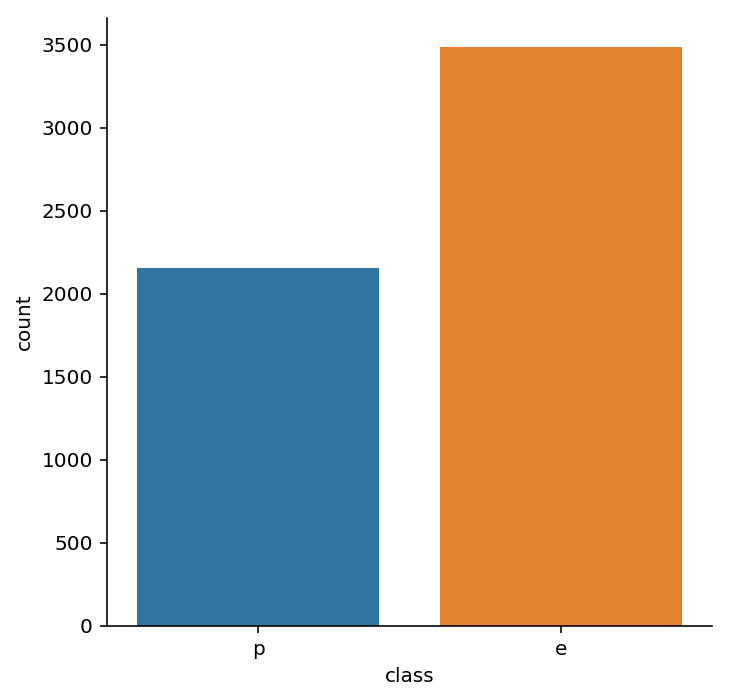

In [33]:
sns.catplot(
    x='class',
    data=df,
    kind='count')

In [34]:
#split off the response variable
y = df['class'].to_frame()
X = df.loc[:, df.columns != 'class']

In [35]:
#encode dummy variables
X_enc = pd.get_dummies(X)

#Scale
scaler = StandardScaler()
X_std = scaler.fit_transform(X_enc)

In [36]:
#encode the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

### Decision trees

In [59]:
param_grid = [{
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]
gs_dt_m = _gridSearchCV(
    tree.DecisionTreeClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [51]:
#Save the metrics
model_name = 'decision tree'
pos_class = 'poisonous'
neg_class = 'edible'
cv_res_dt_m, params_dt_m, gen_res_dt_m, class_res_dt_m, conf_mat_dt_m = getPerfMetrics(gs_dt_m, X_std, y_enc, model_name, pos_class, neg_class)

In [39]:
params_dt_m

,criterion,max_depth
decision tree best parameters,gini,5


In [40]:
gen_res_dt_m

,Accuracy,AUROC-score
decision tree,1.0,1.0


In [41]:
class_res_dt_m

,Precision,Recall,F-score,Support
edible,1.0,1.0,1.0,3488
poisonous,1.0,1.0,1.0,2156


In [52]:
conf_mat_dt_m

,pred edible,pred poisonous
actual edible,0.618001,0.000000
actual poisonous,0.000000,0.381999


In [ ]:
#learning curve
sns.lineplot(
    x='param_max_depth',
    y='mean_train_score',
    hue='param_criterion',
    data=gs_dt_m_res)

In [ ]:
#computational performance
sns.lineplot(
    x='param_max_depth',
    y='mean_fit_time',
    data=cv_res_df_m)

### Boosting

In [ ]:
### Boosting
param_grid = [{
    'n_estimators': list(range(5,25,1)),
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]
gs_rf_m = _gridSearchCV(
    RandomForestClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [ ]:
#Save the metrics
model_name = 'random forests'
cv_res_rf_m, params_rf_m, gen_res_rf_m, class_res_rf_m, conf_mat_rf_m = getPerfMetrics(gs_rf_m, X_std, y_enc, model_name, pos_class, neg_class)

In [ ]:
params_rf_m

In [ ]:
gen_res_rf_m

In [ ]:
class_res_rf_m

In [ ]:
conf_mat_rf_m

### KNN

In [ ]:
param_grid = [{
    'n_neighbors': list(range(1,3,1)),
    'weights': ['uniform','distance'],
    'metric': ['minkowski','manhattan']
}]
gs_knn_m = _gridSearchCV(
    neighbors.KNeighborsClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [26]:
#Save the metrics
model_name = 'kNN'
cv_res_knn_m, params_knn_m, gen_res_knn_m, class_res_knn_m, conf_mat_knn_m = getPerfMetrics(gs_knn_m, X_std, y_enc, model_name, pos_class, neg_class)

NameError: name 'gs_knn_m' is not defined

In [ ]:
params_knn_m

In [ ]:
gen_res_knn_m

In [ ]:
class_res_knn_m

In [ ]:
conf_mat_knn_m

### SVM

In [ ]:
param_grid = [{
    'kernel': ['linear','poly','rbf','sigmoid'],
    'degree': list(range(1,4,1)),
    'decision_function_shape': ['ovr','ovo']
}]
gs_svm_m = _gridSearchCV(
    SVC, 
    param_grid,
    X_std, 
    y_enc)

In [ ]:
#Save the metrics
model_name = 'Support Vector Machines'
cv_res_svm_m, params_svm_m, gen_res_svm_m, class_res_svm_m, conf_mat_svm_m = getPerfMetrics(gs_svm_m, X_std, y_enc, model_name, pos_class, neg_class)

In [ ]:
params_svm_m

In [ ]:
gen_res_svm_m

In [ ]:
class_res_svm_m

In [ ]:
conf_mat_svm_m

### Neural Networks

In [ ]:
param_grid = [{
    'hidden_layer_sizes': [(n,) for n in list(range(1,20,1))],
    'solver': ['lbfgs','sgd','adam'],
    'activation': ['relu','logistic'],
    'learning_rate': ['constant','invscaling']
}]
gs_mlp_m = _gridSearchCV(
    MLPClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [ ]:
#Save the metrics
model_name = 'Neural Network'
cv_res_mlp_m, params_mlp_m, gen_res_mlp_m, class_res_mlp_m, conf_mat_svm_m = getPerfMetrics(gs_mlp_m, X_std, y_enc, model_name, pos_class, neg_class)

In [ ]:
params_svm_m

In [ ]:
gen_res_svm_m

In [ ]:
class_res_svm_m

In [ ]:
conf_mat_svm_m

# Adult incomes
Get the data
## Interests
## Munging

In [53]:
#df = pd.read_csv('datasets/adult/adult.data.txt', header=None)
df = pd.read_csv('https://raw.githubusercontent.com/sventopia/ML/master/datasets/adult/adult.data.txt', header=None)
df.columns = ['age','workclass','fnlwgt','education','education-num','marital-status',
                  'occupation','relationship','race','sex','capital-gain','capital-loss',
                  'hours-per-week','native-country','income']

In [54]:
df = df.drop(['capital-gain','capital-loss'], axis=1)
#split off the response variable
y = df['income'].to_frame()
X = df.loc[:, df.columns != 'income']

In [55]:
#encode the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

#encode dummy variables
X_enc = pd.get_dummies(X)

scaler = StandardScaler()
X_std = scaler.fit_transform(X_enc)

### Decision Trees

In [ ]:
param_grid = [{
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]
gs_dt_a = _gridSearchCV(
    tree.DecisionTreeClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [ ]:
#Save the metrics
model_name = 'decision tree'
pos_class = '> $50k'
neg_class = '<= $50k'
cv_res_dt_a, params_dt_a, gen_res_dt_a, class_res_dt_a, conf_mat_dt_a = getPerfMetrics(gs_dt_a, X_std, y_enc, model_name, pos_class, neg_class)

In [ ]:
params_dt_a

In [ ]:
gen_res_dt_a

In [ ]:
class_res_dt_a

In [ ]:
conf_mat_dt_a

### Boosting

In [ ]:
### Boosting
param_grid = [{
    'n_estimators': list(range(5,25,1)),
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]
gs_rf_a = _gridSearchCV(
    RandomForestClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [ ]:
#Save the metrics
model_name = 'random forests'
cv_res_rf_a, params_rf_a, gen_res_rf_a, class_res_rf_a, conf_mat_rf_a = getPerfMetrics(gs_rf_a, X_std, y_enc, model_name, pos_class, neg_class)



In [ ]:
params_rf_a

In [ ]:
gen_res_rf_a

In [ ]:
class_res_rf_a

In [ ]:
conf_mat_rf_a

### K-nearest neighbors

In [ ]:
param_grid = [{
    'n_neighbors': list(range(1,3,1)),
    'weights': ['uniform','distance'],
    'metric': ['minkowski','manhattan']
}]
gs_knn_a = _gridSearchCV(
    neighbors.KNeighborsClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [ ]:
#Save the metrics
model_name = 'kNN'
cv_res_knn_a, params_knn_a, gen_res_knn_a, class_res_knn_a, conf_mat_knn_a = getPerfMetrics(gs_knn_a, X_std, y_enc, model_name, pos_class, neg_class)


In [ ]:
params_knn_a

In [ ]:
gen_res_knn_a

In [ ]:
class_res_knn_a

In [ ]:
conf_mat_knn_a

### SVM

In [ ]:
param_grid = [{
    'kernel': ['linear','poly','rbf','sigmoid'],
    'degree': list(range(1,4,1)),
    'decision_function_shape': ['ovr','ovo']
}]
gs_svm_a = _gridSearchCV(
    SVC, 
    param_grid,
    X_std, 
    y_enc)

In [ ]:
#Save the metrics
model_name = 'Support Vector Machines'
cv_res_svm_a, params_svm_a, gen_res_svm_a, class_res_svm_a, conf_mat_svm_a = getPerfMetrics(gs_svm_a, X_std, y_enc, model_name, pos_class, neg_class)

In [ ]:
params_svm_a

In [ ]:
gen_res_svm_a

In [ ]:
class_res_svm_a

In [ ]:
conf_mat_svm_a

### Neural Networks

In [ ]:
param_grid = [{
    'hidden_layer_sizes': [(n,) for n in list(range(1,20,1))],
    'solver': ['lbfgs','sgd','adam'],
    'activation': ['relu','logistic'],
    'learning_rate': ['constant','invscaling']
}]
gs_mlp_a = _gridSearchCV(
    MLPClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [ ]:
#Save the metrics
model_name = 'Neural Network'
cv_res_mlp_a, params_mlp_a, gen_res_mlp_a, class_res_mlp_a, conf_mat_svm_a = getPerfMetrics(gs_mlp_a, X_std, y_enc, model_name, pos_class, neg_class)


In [ ]:
params_mlp_a

In [ ]:
gen_res_mlp_a

In [ ]:
class_res_mlp_a

In [ ]:
conf_mat_svm_a